In [1]:
from h5py import File as HDF5File
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from IPython.display import clear_output
sns.set()

def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

device = torch.device('cuda:2')

## Loading data

In [2]:
N = -1

data_real = np.load('./real_quan.npz', allow_pickle=True)
EnergyDeposit = data_real['EnergyDeposit']
EnergyDeposit = EnergyDeposit.reshape(-1, 1, 30, 30)[:N]
ParticleMomentum = data_real['ParticleMomentum'][:N]
ParticlePoint = data_real['ParticlePoint'][:N, :2]

## Load it to pytorch `DataLoader`

In [3]:
EnergyDeposit = torch.tensor(EnergyDeposit).float()
ParticleMomentum = torch.tensor(ParticleMomentum).float()
ParticlePoint = torch.tensor(ParticlePoint).float()

BATCH_SIZE = 1024
calo_dataset = utils.TensorDataset(EnergyDeposit, ParticleMomentum, ParticlePoint)
calo_dataloader = torch.utils.data.DataLoader(calo_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)

In [4]:
for EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b in calo_dataloader:
    break

## Three types of losses for GANs

https://medium.com/@jonathan_hui/gan-what-is-wrong-with-the-gan-cost-function-6f594162ce01

### Task `KL`

$$loss_g = \log(1 - \mathrm{discriminator}(\mathrm{gen}))$$

$$loss_d = - \log(\mathrm{discriminator}(\mathrm{gen})) - \log(1 - \mathrm{discriminator}(\mathrm{real}))$$


### Task `REVERSED_KL`

$$loss_g = - \log(\mathrm{discriminator}(\mathrm{gen}))$$

$$loss_d = - \log(\mathrm{discriminator}(\mathrm{gen})) - \log(1 - \mathrm{discriminator}(\mathrm{real}))$$


### Task `WASSERSTEIN`

$$loss_g = - \mathrm{discriminator}(\mathrm{gen})$$

$$loss_d = \mathrm{discriminator}(\mathrm{gen}) - \mathrm{discriminator}(\mathrm{real})$$

In [5]:
TASKS = ['KL', 'REVERSED_KL', 'WASSERSTEIN']

## 

https://arxiv.org/pdf/1801.04406.pdf

In [6]:
TASK = 'REVERSED_KL'
LIPSITZ_WEIGHTS = False

# https://arxiv.org/abs/1704.00028
GRAD_PENALTY = False

# https://arxiv.org/abs/1705.09367
ZERO_CENTERED_GRAD_PENALTY = False

# https://arxiv.org/abs/1610.04490
INSTANCE_NOISE = False

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch


class GANLosses(object):
    def __init__(self, task, device):
        self.TASK = task
        self.device = device
    
    def g_loss(self, discrim_output):
        eps = 1e-10
        if self.TASK == 'KL': 
            loss = torch.log(1 - discrim_output + eps).mean()    
        elif self.TASK == 'REVERSED_KL':
            loss = - torch.log(discrim_output + eps).mean()
        elif self.TASK == 'WASSERSTEIN':
            loss = - discrim_output.mean()
        return loss

    def d_loss(self, discrim_output_gen, discrim_output_real):
        eps = 1e-10
        if self.TASK in ['KL', 'REVERSED_KL']: 
            loss = - torch.log(discrim_output_real + eps).mean() - torch.log(1 - discrim_output_gen + eps).mean()
        elif self.TASK == 'WASSERSTEIN':
            loss = - (discrim_output_real.mean() - discrim_output_gen.mean())
        return loss

    def calc_gradient_penalty(self, discriminator, data_gen, inputs_batch, inp_data, lambda_reg = .1):
        alpha = torch.rand(inp_data.shape[0], 1).to(self.device)
        dims_to_add = len(inp_data.size()) - 2
        for i in range(dims_to_add):
            alpha = alpha.unsqueeze(-1)
        # alpha = alpha.expand(inp_data.size())

        interpolates = (alpha * inp_data + ((1 - alpha) * data_gen)).to(self.device)

        interpolates.requires_grad = True

        disc_interpolates = discriminator(interpolates, inputs_batch)

        gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(self.device),
                                        create_graph=True, retain_graph=True, only_inputs=True)[0]

        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_reg
        return gradient_penalty
    
    def calc_zero_centered_GP(self, discriminator, data_gen, inputs_batch, inp_data, gamma_reg = .1):
        
        local_input = inp_data.clone().detach().requires_grad_(True)
        disc_interpolates = discriminator(local_input, inputs_batch)
        gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=local_input,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(self.device),
                                        create_graph=True, retain_graph=True, only_inputs=True)[0]
        return gamma_reg / 2 * (gradients.norm(2, dim=1) ** 2).mean() 

In [8]:
class ModelD(nn.Module):
    def __init__(self):
        super(ModelD, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout = nn.Dropout(p=0.1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.conv4 = nn.Conv2d(64, 32, 3)
        
        # size
        self.fc1 = nn.Linear(2592 + 5, 512) 
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        
    def forward(self, EnergyDeposit, ParticleMomentum_ParticlePoint):
        EnergyDeposit = self.dropout(F.leaky_relu(self.bn1(self.conv1(EnergyDeposit))))
        EnergyDeposit = self.dropout(F.leaky_relu(self.bn2(self.conv2(EnergyDeposit))))
        EnergyDeposit = F.leaky_relu(self.conv3(EnergyDeposit))
        EnergyDeposit = F.leaky_relu(self.conv4(EnergyDeposit)) # 32, 9, 9
        EnergyDeposit = EnergyDeposit.view(len(EnergyDeposit), -1)
        
        t = torch.cat([EnergyDeposit, ParticleMomentum_ParticlePoint], dim=1)
        
        t = F.leaky_relu(self.fc1(t))
        t = F.leaky_relu(self.fc2(t))
        t = F.leaky_relu(self.fc3(t))
        if TASK == 'WASSERSTEIN':
            return self.fc4(t)
        else:
            return torch.sigmoid(self.fc4(t))

In [9]:
class ModelGConvTranspose(nn.Module):
    def __init__(self, z_dim):
        self.z_dim = z_dim
        super(ModelGConvTranspose, self).__init__()
        self.fc1 = nn.Linear(self.z_dim + 2 + 3, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 2592)
        
        self.conv4 = nn.ConvTranspose2d(16, 1, 3)
        self.conv3 = nn.ConvTranspose2d(64, 16, 3, stride=2, output_padding=1)
        self.conv2 = nn.ConvTranspose2d(64, 64, 3)
        self.conv1 = nn.ConvTranspose2d(32, 64, 3)
        
        
    def forward(self, z, ParticleMomentum_ParticlePoint):
        x = F.leaky_relu(self.fc1(
            torch.cat([z, ParticleMomentum_ParticlePoint], dim=1)
        ))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        
        EnergyDeposit = x.view(-1, 32, 9, 9)
        
        EnergyDeposit = F.leaky_relu(self.conv1(EnergyDeposit))
        EnergyDeposit = F.leaky_relu(self.conv2(EnergyDeposit))
        EnergyDeposit = F.leaky_relu(self.conv3(EnergyDeposit))
        EnergyDeposit = self.conv4(EnergyDeposit)
        
        return EnergyDeposit
    
class ModelGUpscale(nn.Module):
    def __init__(self, z_dim):
        self.z_dim = z_dim
        super(ModelGUpscale, self).__init__()
        self.fc1 = nn.Linear(self.z_dim + 2 + 3, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 2592 * 2)
        
        self.conv5 = nn.Conv2d(16, 1, 3, stride=1, padding=1)
        
        self.conv4 = nn.Conv2d(32, 16, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 32, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, stride=1, padding=0)
        self.conv1 = nn.Conv2d(64, 64, 3, stride=1, padding=0)
        
    def forward(self, z, ParticleMomentum_ParticlePoint):
        x = F.leaky_relu(self.fc1(
            torch.cat([z, ParticleMomentum_ParticlePoint], dim=1)
        ))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        
        EnergyDeposit = x.view(-1, 64, 9, 9)
        
        EnergyDeposit = F.leaky_relu(self.conv1(F.interpolate(EnergyDeposit, scale_factor=2)))
        EnergyDeposit = F.leaky_relu(self.conv2(F.interpolate(EnergyDeposit, scale_factor=2)))
        EnergyDeposit = F.leaky_relu(self.conv3(F.interpolate(EnergyDeposit, scale_factor=2)))
        EnergyDeposit = F.leaky_relu(self.conv4(F.interpolate(EnergyDeposit, scale_factor=1)))
        
        return self.conv5(EnergyDeposit)

In [10]:
NOISE_DIM = 2

discriminator = ModelD().to(device)
generator = ModelGConvTranspose(z_dim=NOISE_DIM).to(device)
# generator = ModelGUpscale(z_dim=NOISE_DIM).to(device)

In [11]:
EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b = EnergyDeposit_b.to(device), \
                                                       ParticleMomentum_b.to(device), \
                                                       ParticlePoint_b.to(device)
ParticleMomentum_ParticlePoint_b = torch.cat([ParticleMomentum_b.to(device), ParticlePoint_b.to(device)], dim=1)

In [12]:
EnergyDeposit_b.shape

torch.Size([1024, 1, 30, 30])

In [13]:
discriminator(EnergyDeposit_b, ParticleMomentum_ParticlePoint_b).shape

torch.Size([1024, 1])

In [14]:
noise = torch.randn(len(EnergyDeposit_b), NOISE_DIM).to(device)
generator(noise, ParticleMomentum_ParticlePoint_b).shape

torch.Size([1024, 1, 30, 30])

In [15]:
learning_rate_dis = 1e-3
learning_rate_gen = 1e-3

g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate_gen, weight_decay=1e-6)
d_optimizer = optim.SGD(discriminator.parameters(), lr=learning_rate_dis, weight_decay=1e-6)

In [16]:
from prd_score import compute_prd, compute_prd_from_embedding, _prd_to_f_beta
from sklearn.metrics import auc

In [17]:
def add_instance_noise(data, std=0.01):
    return data + torch.distributions.Normal(0, std).sample(data.shape).to(device)

In [18]:
clamp_lower, clamp_upper = -0.01, 0.01

def run_training():

    # ===========================
    # IMPORTANT PARAMETER:
    # Number of D updates per G update
    # ===========================
    k_d, k_g = 1, 1

    gan_losses = GANLosses(TASK, device)
    dis_epoch_loss = []
    gen_epoch_loss = []
    predictions_dis = []
    predictions_gen = []
    prd_auc = []  
    for epoch in tqdm(range(1000)):
        first = True
        
        for EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b in calo_dataloader:
            EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b = EnergyDeposit_b.to(device), \
                                                                   ParticleMomentum_b.to(device), \
                                                                   ParticlePoint_b.to(device)
            ParticleMomentum_ParticlePoint_b = torch.cat([ParticleMomentum_b.to(device), ParticlePoint_b.to(device)], dim=1)
            if first:
                noise = torch.randn(len(EnergyDeposit_b), NOISE_DIM).to(device)
                EnergyDeposit_gen = generator(noise, ParticleMomentum_ParticlePoint_b)
                predictions_dis.append(
                    list(discriminator(EnergyDeposit_b, ParticleMomentum_ParticlePoint_b).detach().cpu().numpy().ravel())
                )

                predictions_gen.append(
                    list(discriminator(EnergyDeposit_gen, ParticleMomentum_ParticlePoint_b).detach().cpu().numpy().ravel())
                )
            # Optimize D
            for _ in range(k_d):
                noise = torch.randn(len(EnergyDeposit_b), NOISE_DIM).to(device)
                EnergyDeposit_gen = generator(noise, ParticleMomentum_ParticlePoint_b)
                loss = gan_losses.d_loss(discriminator(EnergyDeposit_gen, ParticleMomentum_ParticlePoint_b),
                                         discriminator(EnergyDeposit_b, ParticleMomentum_ParticlePoint_b))
                if GRAD_PENALTY:
                    grad_penalty = gan_losses.calc_gradient_penalty(discriminator,
                                                                    EnergyDeposit_gen.data,
                                                                    ParticleMomentum_ParticlePoint_b,
                                                                    EnergyDeposit_b.data)
                    loss += grad_penalty
                elif ZERO_CENTERED_GRAD_PENALTY:
                    grad_penalty = gan_losses.calc_zero_centered_GP(discriminator,
                                                                    EnergyDeposit_gen.data,
                                                                    ParticleMomentum_ParticlePoint_b,
                                                                    EnergyDeposit_b.data)
                    loss -= grad_penalty

                d_optimizer.zero_grad()
                loss.backward()
                d_optimizer.step()
                if LIPSITZ_WEIGHTS:                    
                    [p.data.clamp_(clamp_lower, clamp_upper) for p in discriminator.parameters()]

            dis_epoch_loss.append(loss.item())

            # Optimize G
            for _ in range(k_g):
                noise = torch.randn(len(EnergyDeposit_b), NOISE_DIM).to(device)
                EnergyDeposit_gen = generator(noise, ParticleMomentum_ParticlePoint_b)
                loss = gan_losses.g_loss(discriminator(EnergyDeposit_gen, ParticleMomentum_ParticlePoint_b))
                g_optimizer.zero_grad()
                loss.backward()
                g_optimizer.step()
                
            gen_epoch_loss.append(loss.item())
            if first:
                precision, recall = compute_prd_from_embedding(
                    EnergyDeposit_gen.detach().cpu().numpy().reshape(BATCH_SIZE, -1), 
                    EnergyDeposit_b.detach().cpu().numpy().reshape(BATCH_SIZE, -1),
                    num_clusters=30,
                    num_runs=100)
                prd_auc.append(auc(precision, recall))
                first = False
        
        clear_output()
        plt.figure(figsize=(12, 12))
        plt.plot(dis_epoch_loss, label='dis_epoch_loss')
        plt.plot(gen_epoch_loss, label='gen_epoch_loss')
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(12, 12))
        plt.hist(predictions_dis[-1], bins=100, label='dis_epoch_loss')
        plt.hist(predictions_gen[-1], bins=100, label='gen_epoch_loss')
        plt.legend()
        plt.show()
        print(np.mean(predictions_dis[-1]), np.mean(predictions_gen[-1]))
        
        plt.figure(figsize=(12, 12))
        plt.plot(prd_auc, label='prd_auc')
        plt.plot()
        plt.legend()
        plt.show()

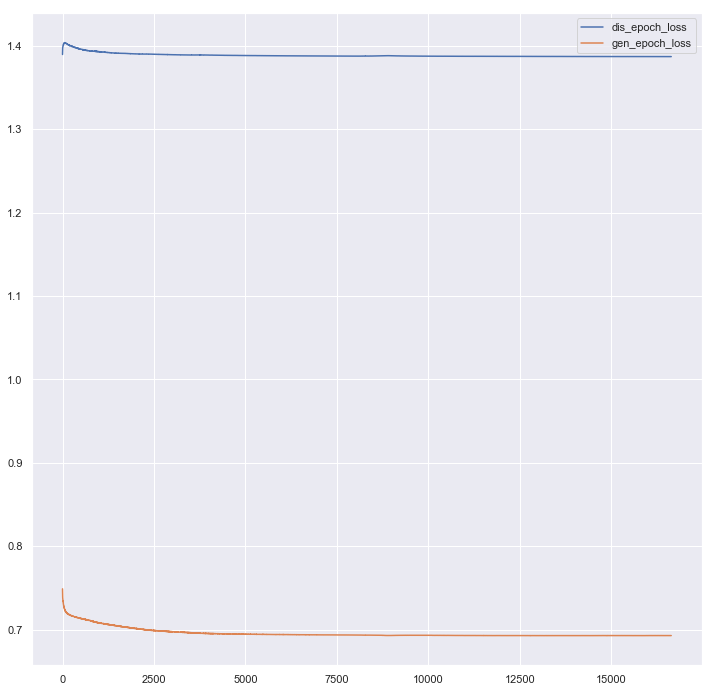

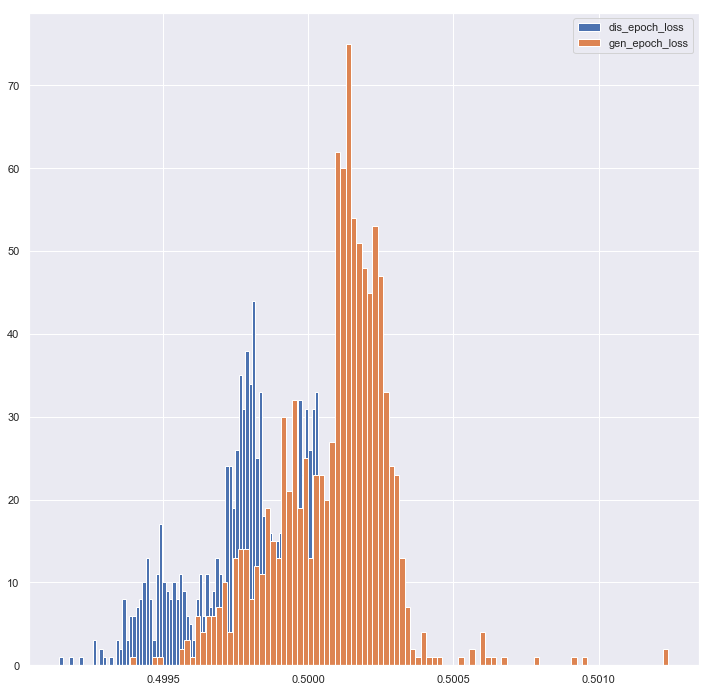

0.49978894 0.5000864


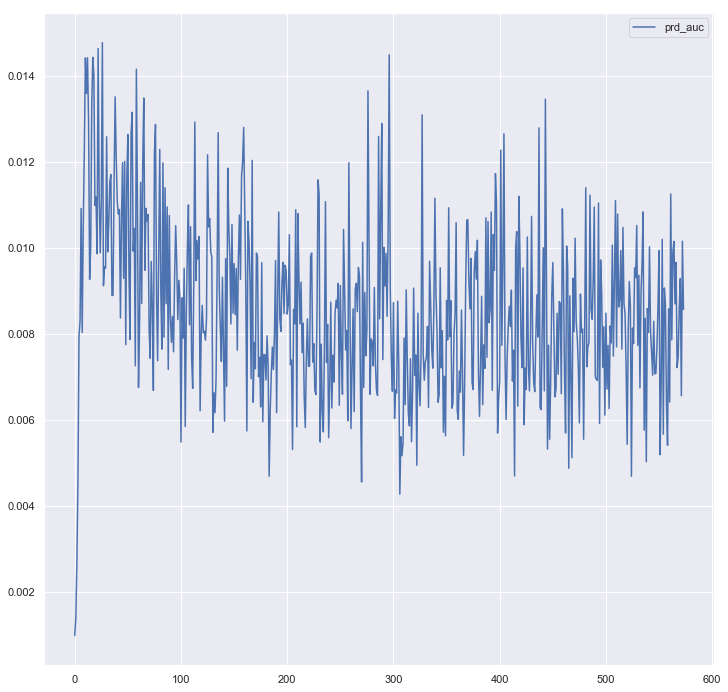

 57%|█████▋    | 574/1000 [9:07:15<6:46:36, 57.27s/it]

In [ ]:
run_training()

In [ ]:
from prd_score import compute_prd, compute_prd_from_embedding, _prd_to_f_beta
from sklearn.metrics import auc
noise = torch.randn(BATCH_SIZE, NOISE_DIM).to(device)
ParticleMomentum_ParticlePoint_b = torch.cat([ParticleMomentum_b.to(device), 
                                              ParticlePoint_b.to(device)], dim=1)
EnergyDeposit_gen = generator(noise, ParticleMomentum_ParticlePoint_b)

In [ ]:
precision, recall = compute_prd_from_embedding(
                    EnergyDeposit_gen.detach().cpu().numpy().reshape(BATCH_SIZE, -1), 
                    EnergyDeposit_b.detach().cpu().numpy().reshape(BATCH_SIZE, -1),
                    num_clusters=30,
                    num_runs=100)

In [ ]:
plt.figure(figsize=(12, 12))

plt.step(recall, precision, color='b', alpha=0.2,  where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

In [ ]:
plt.imshow(EnergyDeposit_gen[0, 0].detach().cpu().numpy())
plt.colorbar()